# HW11 - Descriptive Notebook

In this homework notebook, we will create a Wasserstein GAN with Convolution and Transpose Convolution layers, to be used on the MNIST dataset.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 18th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

**Name: Loh De Rong**

**Student ID: 1003557**

### Imports needed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch import Tensor
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and dataloader

In [3]:
# Image transform to be applied to dataset
# - Tensor conversion
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# MNIST train dataset
mnist = torchvision.datasets.MNIST(root = './data/',
                                   train = True,
                                   transform = transform,
                                   download = True)

In [5]:
# Data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset = mnist,
                                          batch_size = batch_size, 
                                          shuffle = True)

### Critic model as a set of Conv2d layers

**Task1:** Rewrite the Critic model below, so that it uses Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebook 3 (W11S1 lecture).

The critic should use three Conv2d layers with progressive downsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [6]:
# Critic
class Critic(nn.Module):
    
    def __init__(self, image_size):
        """
        Only forced parameter will be the image size, set to 28.
        """
        # Init from nn.Module
        super().__init__()
        
        # Conv layers
        self.D = nn.Sequential(nn.Conv2d(1, 128, 7, stride = 2),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(128, 256, 5, stride = 2, padding = 1),
                               nn.LeakyReLU(0.2),
                               nn.Conv2d(256, 1, 5, stride = 1)) 
                
    def forward(self, x):
        return self.D(x)

### Generator model as a set of Transposed Conv2d layers

**Task2:** Rewrite the Generator model below, so that it uses Transposed Conv2d layers instead of fully connected ones shown in class.

You may look for inspiration in the encoder models used in Notebooks 2 and 3 (W11S1 lecture).

The critic should use three Transposed Conv2d layers with progressive upsampling.

We do not advise to add more layers to the mix (BatchNorm, Dropout, etc.).

In [7]:
# Generator
class Generator(nn.Module):
    
    def __init__(self, latent_size, image_size):
        """
        Only forced parameters will be the image size, set to 28,
        and the latent size set to 64.
        """
        # Init from nn.Module
        super().__init__()
        
        # ConvTranspose layers
        self.G = nn.Sequential(nn.ConvTranspose2d(latent_size, 32, 7, stride = 1),
                               nn.LeakyReLU(0.2),
                               nn.ConvTranspose2d(32, 16, 3, stride = 2, output_padding = 1, padding = 1),
                               nn.LeakyReLU(0.2),
                               nn.ConvTranspose2d(16, 1, 3, stride = 2, output_padding = 1, padding = 1),
                               nn.Tanh())
        
    def forward(self, x):
        return self.G(x)

### Trainer function

**Task 3:** Decide on a number of iterations num_epochs for training!

In [8]:
# Hyperparameters for model generation and training
latent_size = 64
image_size = 28
num_epochs = 20
batch_size = 32

In [9]:
# Create discriminator model
f = Critic(image_size)
f.to(device)

Critic(
  (D): Sequential(
    (0): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

In [10]:
# Create generator model
G = Generator(latent_size, image_size)
G.to(device)

Generator(
  (G): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Tanh()
  )
)

In [11]:
# Losses and optimizers
d_optimizer = torch.optim.Adam(f.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [12]:
# History trackers for training curves
# Keeping track of losses
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)

**Note: running the cell below (our trainer function) will take a long time!**

In [13]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        
        # 1. Send image to device
        images = Variable(images.to(device), requires_grad = True)
        
        """
        PART 1: TRAIN THE CRITIC
        """

        for j in range(3):
            # 2. Compute mean of critic decisions using real images
            outputs_real = f(images)

            # 2.bis. Compute mean of critic decisions using fake images
            z = torch.randn(batch_size, latent_size, 1, 1).to(device)
            z = Variable(z)
            fake_images = G(z)
            outputs_fake = f(fake_images)

            # 3. Compute gradient regularization
            real_grad_out = Variable(Tensor(images.size(0), 1, 1, 1).fill_(1.0), requires_grad = False).to(device)
            real_grad = autograd.grad(outputs_real, images, real_grad_out, create_graph = True, \
                                      retain_graph = True, only_inputs = True)[0]
            real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1)**3
            fake_grad_out = Variable(Tensor(fake_images.size(0), 1, 1, 1).fill_(1.0), requires_grad = False).to(device)
            fake_grad = autograd.grad(outputs_fake, fake_images, fake_grad_out, create_graph = True, \
                                      retain_graph = True, only_inputs = True)[0]
            fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1)**3
            reg_term = torch.mean(real_grad_norm + fake_grad_norm)

            # 4. Backprop and optimize for f
            # Loss is simply the difference between means, plus regularization term
            # Remember to reset gradients for both optimizers!
            d_loss = -torch.mean(outputs_real) + torch.mean(outputs_fake) + reg_term
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 4.bis. Optional, weight clipping on critic
            # (Mentioned in WGAN paper)
            for p in f.parameters():
                p.data.clamp_(-0.01, 0.01)
        
        """
        PART 2: TRAIN THE GENERATOR
        """

        # 5. Generate fresh noise samples and produce fake images
        z = torch.randn(batch_size, latent_size, 1, 1).cuda()
        z = Variable(z)
        fake_images = G(z)
        outputs = f(fake_images)
        
        # 6. Loss for G
        g_loss = - torch.mean(outputs)
        
        # 7. Backprop and optimize G
        # Remember to reset gradients for both optimizers!
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        
        """
        PART 3: UPDATE STATISTICS FOR VISUALIZATION LATER
        """
        
        # 8. Update the losses and scores for mini-batches
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) \
            + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) \
            + g_loss.item()*(1./(i+1.))
        
        # 9. Display
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))

Epoch [0/20], Step [200/1875], d_loss: -3.8647, g_loss: -1.2256
Epoch [0/20], Step [400/1875], d_loss: -1.6865, g_loss: 0.0088
Epoch [0/20], Step [600/1875], d_loss: -1.4990, g_loss: -1.4417
Epoch [0/20], Step [800/1875], d_loss: -1.4334, g_loss: -0.1695
Epoch [0/20], Step [1000/1875], d_loss: -1.4563, g_loss: -0.0566
Epoch [0/20], Step [1200/1875], d_loss: -1.5848, g_loss: 1.5721
Epoch [0/20], Step [1400/1875], d_loss: -1.0860, g_loss: -1.9940
Epoch [0/20], Step [1600/1875], d_loss: -1.2359, g_loss: -0.7748
Epoch [0/20], Step [1800/1875], d_loss: -1.2512, g_loss: -0.0139
Epoch [1/20], Step [200/1875], d_loss: -1.0788, g_loss: 0.7702
Epoch [1/20], Step [400/1875], d_loss: -1.1411, g_loss: 1.7021
Epoch [1/20], Step [600/1875], d_loss: -1.1684, g_loss: -0.2827
Epoch [1/20], Step [800/1875], d_loss: -0.9837, g_loss: -1.4538
Epoch [1/20], Step [1000/1875], d_loss: -0.9965, g_loss: -0.5356
Epoch [1/20], Step [1200/1875], d_loss: -0.9294, g_loss: 1.2354
Epoch [1/20], Step [1400/1875], d_loss

Epoch [14/20], Step [400/1875], d_loss: -0.4491, g_loss: -1.9381
Epoch [14/20], Step [600/1875], d_loss: -0.4175, g_loss: 0.1951
Epoch [14/20], Step [800/1875], d_loss: -0.3666, g_loss: -1.2227
Epoch [14/20], Step [1000/1875], d_loss: -0.1474, g_loss: -2.2765
Epoch [14/20], Step [1200/1875], d_loss: -0.3080, g_loss: -0.6311
Epoch [14/20], Step [1400/1875], d_loss: -0.6293, g_loss: -2.4782
Epoch [14/20], Step [1600/1875], d_loss: -0.4096, g_loss: -1.1839
Epoch [14/20], Step [1800/1875], d_loss: -0.5377, g_loss: -3.0781
Epoch [15/20], Step [200/1875], d_loss: -0.4078, g_loss: -1.1171
Epoch [15/20], Step [400/1875], d_loss: -0.3657, g_loss: -2.0694
Epoch [15/20], Step [600/1875], d_loss: -0.4864, g_loss: -2.1209
Epoch [15/20], Step [800/1875], d_loss: -0.3275, g_loss: -0.1371
Epoch [15/20], Step [1000/1875], d_loss: -0.3880, g_loss: 0.1285
Epoch [15/20], Step [1200/1875], d_loss: -0.2946, g_loss: -3.8290
Epoch [15/20], Step [1400/1875], d_loss: -0.7396, g_loss: -3.5749
Epoch [15/20], Step

### Visualization

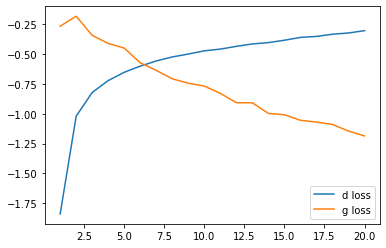

In [14]:
# Display losses for both the generator and discriminator
plt.figure()
plt.plot(range(1, num_epochs + 1), d_losses, label = 'd loss')
plt.plot(range(1, num_epochs + 1), g_losses, label = 'g loss')    
plt.legend()
plt.show()

In [15]:
# Generate a few fake samples (5 of them) for visualization
n_samples = 5
z = torch.randn(n_samples, latent_size, 1, 1).cuda()
z = Variable(z)
fake_images = G(z)
fake_images = fake_images.cpu().detach().numpy().reshape(n_samples, 28, 28)
print(fake_images.shape)

(5, 28, 28)


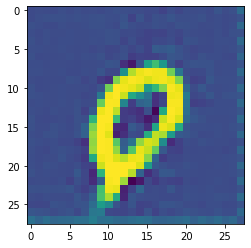

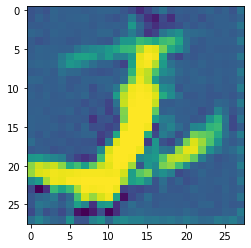

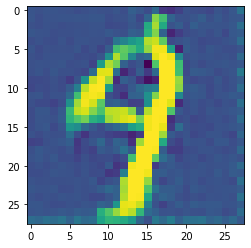

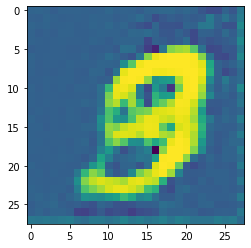

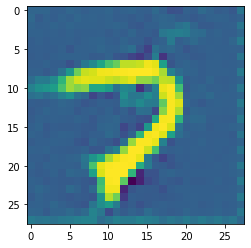

In [16]:
# Display
plt.figure()
plt.imshow(fake_images[0])
plt.show()
plt.figure()
plt.imshow(fake_images[1])
plt.show()
plt.figure()
plt.imshow(fake_images[2])
plt.show()
plt.figure()
plt.imshow(fake_images[3])
plt.show()
plt.figure()
plt.imshow(fake_images[4])
plt.show()

### Questions and expected answers for the report

**1. Copy and paste the code for your Critic class. Briefly explain your choice of architecture.**

    # Critic
    class Critic(nn.Module):

        def __init__(self, image_size):
            """
            Only forced parameter will be the image size, set to 28.
            """
            # Init from nn.Module
            super().__init__()

            # Conv layers
            self.D = nn.Sequential(nn.Conv2d(1, 128, 7, stride = 2),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(128, 256, 5, stride = 2, padding = 1),
                                   nn.LeakyReLU(0.2),
                                   nn.Conv2d(256, 1, 5, stride = 1)) 

        def forward(self, x):
            return self.D(x)

For the first two layers, the number of channels progressively increases while the spatial dimension decreases. This is to capture more high-level concepts in different activation maps. The use of LeakyRelu could help introduce non-linearity as well as ensure the invertibility property, in the hopes of more effective learning.


**2. Copy and paste the code for your Generator class. Briefly explain your choice of architecture.**

    # Generator
    class Generator(nn.Module):

        def __init__(self, latent_size, image_size):
            """
            Only forced parameters will be the image size, set to 28,
            and the latent size set to 64.
            """
            # Init from nn.Module
            super().__init__()

            # ConvTranspose layers
            self.G = nn.Sequential(nn.ConvTranspose2d(latent_size, 32, 7, stride = 1),
                                   nn.LeakyReLU(0.2),
                                   nn.ConvTranspose2d(32, 16, 3, stride = 2, output_padding = 1, padding = 1),
                                   nn.LeakyReLU(0.2),
                                   nn.ConvTranspose2d(16, 1, 3, stride = 2, output_padding = 1, padding = 1),
                                   nn.Tanh())

        def forward(self, x):
            return self.G(x)

The number of channels progressively decreases while the spatial dimension increases through upsampling. In particular, the use of deconvolutional layers has learnable parameters that can be updated during backpropagation. The use of LeakyRelu could help introduce non-linearity as well as ensure the invertibility property, in the hopes of more effective learning. The use of Tanh activation function in the final layer is to normalize the image.

**3. For how many iterations did you have to train when using Wasserstein with Conv/TransposeConv layers to get plausible images from the generator? Is it training faster than the Fully Connected Wasserstein/Vanilla GAN?**

I had to train for around 20 epochs. In terms of the amount of training time required for convergence, training using Wasserstein with Conv/TransposeConv layers is faster than with Fully Connected Wasserstein/Vanilla GAN. This is likely because the convolutional layers can perform better as feature extractor.

However, in terms of training time per epoch, it takes longer to train with Conv/TransposeConv layers. This is because there are more parameters for the convolutional layers (due to the large number of input and output channels) than the Fully Connected layers, as well as more convolutions (and hence scalar multiplications) that need to be performed, resulting in longer time for each pass. 

During my training, I realize that my Generator model was overpowering my Critic model, so it was very difficult for my Critic model to learn and discriminate the fake images in this kind of 1-to-1 interleaved training mode. As a result, there was no incentive for the Generator model to produce more plausible images to trick the Critic model. Therefore, I also increased the number of training iterations for my Critic model to give it more training time, as compared to the Generator model. This evens out the learning capability of each model, which helps in the training of the Generator model to produce more plausible images, but at the expense of more training time for every epoch.

**4. Display some samples generated by your trained generator. Do they look plausible?**

Refer to the images shown. The images are plausible, but not as great as the Fully Connected Wasserstein/Vanilla GAN.

**5. Let us assume we use Conv2d layers in the Critic. We do NOT use Transposed Conv2d layers, but only Fully Connected layers in the Generator. Would the GAN still be able to train both models or would it encounter difficulties? Discuss.**

Yes, the GAN would still be able to train both models. Fully connected layers can approximate any functions, and should be able 
to generate plausible images with sufficient learning. However, the models using Fully Connected layers might face more difficulty in picking up local features, and take a time longer time to converge.